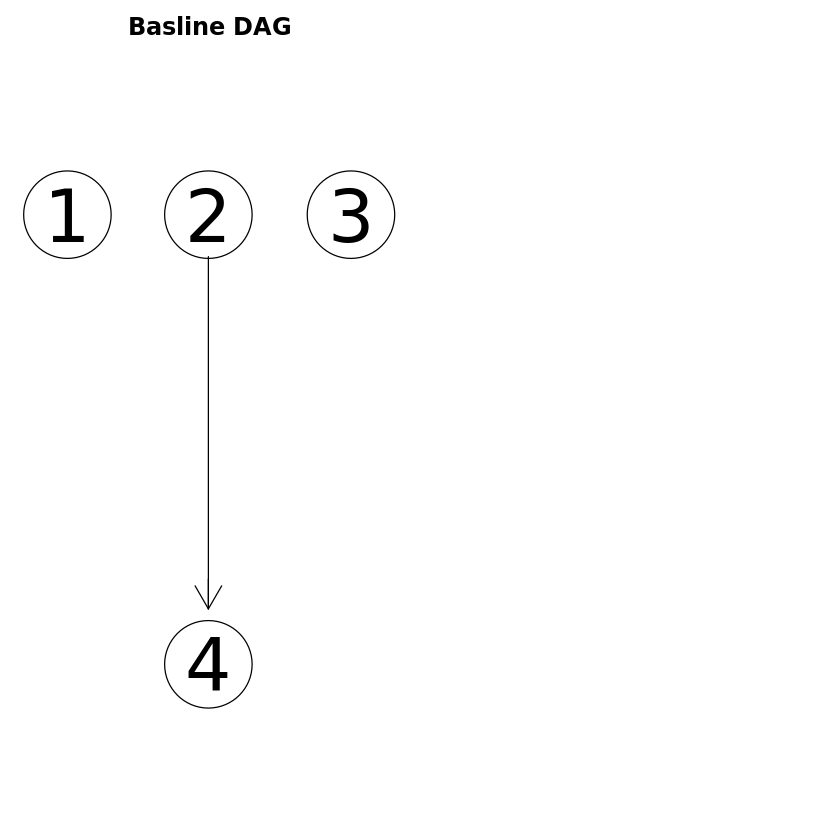

In [19]:
library("Rgraphviz")
#--------------------------------------------------------------
# Generation of random DAG representing assumed causal relationships
#--------------------------------------------------------------

set.seed(314)

# Function that generates a random DAG based on an edge list V and connecting probability p and weighting bounds lB,uB
generateDAG <- function ( p=0.4 , V, lB = 0.2, uB = 1){# p=0.4 as default
  n <- length(V) # number of vertices
  
  # weights
  edL <- vector("list", n)
    nmbEdges <- 0L
  for (i in seq_len(n - 2)) {
    listSize <- rbinom(1, n - i, p)
    nmbEdges <- nmbEdges + listSize
    edgeList <- sample(seq(i + 1, n), size = listSize)
    weightList <- runif(length(edgeList), min = lB, max = uB) 
    edL[[i]] <- list(edges = edgeList, weights = weightList)
  }
  
  ## i=n-1 separately
  listSize <- rbinom(1, 1, p)
  if (listSize > 0) {
    nmbEdges <- nmbEdges + 1
    edgeList <- n
    weightList <- runif(1, min = lB, max = uB)
  } else {
    edgeList <- integer(0)
    weightList <- numeric(0)
  }
  edL[[n-1]] <- list(edges = edgeList, weights = weightList)
  if (nmbEdges > 0) {
    edL[[n]] <- list(edges = integer(0), weights = numeric(0))
    names(edL) <- V
    new("graphNEL", nodes = V, edgeL = edL, edgemode = "directed")
  }
  else
    new("graphNEL", nodes = V, edgemode = "directed")
}


#--------------------------------------------------------------
# Example
#--------------------------------------------------------------

N <- 5 # Number of Vertices
V <- c(as.character(1:N)) # Character Vector of N node names
p <- 0.5 # Probability for Edge between two vertices

trueDAG <- generateDAG(p, V) ## true DAG

# GRAPH Properties
#trueDAG
#trueDAG@edgeL #EdgeList
#trueDAG@edgeData #EdgeWeights


# Plot
par(mfrow = c(1,2))
plot(trueDAG, main = "Basline DAG")



In [14]:
library("graph")
#--------------------------------------------------------------
# simulate normal distributed data from the true DAG
#--------------------------------------------------------------

# Function that generates n random observations according to the causal structure of the DAG under the assumption of normal node distributions

generateData <-  function(n, DAG, errMat = NULL){ 
  
    weightMatrix <- t(as(DAG,"matrix"))
    N <- length(nodes(DAG))
  
    if(is.null(errMat)) {
        errMat <- matrix(rnorm(n*N),  nrow = n)
    }
    else { 
      stopifnot(!is.null(dim.eM <- dim(errMat)),
                dim.eM == c(n,N), is.numeric(errMat))
    }
    colnames(errMat) <- colnames(weightMatrix)
    ## compute X matrix X_i
    if (sum(weightMatrix) > 0) {
      X <- errMat
      for (j in 2:N) { ## uses X[*, 1:(j-1)] -- "recursively" !
        ij <- 1:(j-1)
        X[,j] <- X[,j] + X[, ij, drop = FALSE] %*% weightMatrix[j, ij]
      }
      X
    }
    else
      errMat
  }
 


#--------------------------------------------------------------
# Example - extended
#--------------------------------------------------------------


n <- 24 * 7 * 60
df <- generateData(n, trueDAG)
    



1,2,3,4,5,6,7,8,9,10
-0.4134564,0.1445327,0.47713704,1.03094871,-0.2065890,0.96853133,0.13326634,1.66641925,3.1899257,-0.55097030
-1.1219741,-0.3184924,0.48996877,-1.40262365,-0.8127403,-0.99894552,2.26041503,-0.01131717,-1.3050967,-1.05150639
0.8361390,-0.4871467,0.06426016,0.46528914,0.9442428,-0.06240593,1.18417061,-0.32966192,2.0759150,-0.84171223
1.3574051,1.8775880,-1.23859059,1.87483501,1.2370358,-0.02849802,0.07126231,0.10486754,0.3113597,-0.03755033
1.2764198,-1.3762686,0.15766691,0.09666391,-0.2931033,-0.35527192,-1.68386703,0.46236601,1.2263475,-2.21960365
0.1290661,0.2383398,-1.11097767,0.40982864,1.5746185,0.63230556,-0.37232093,1.15808254,1.1814309,0.12284024


In [ ]:
# Create Log Data 

In [ ]:
# Create Observational Data
# for x 
#

# every value within a row has a different time between window, collect all windows
# 


1,2,3,4,5,6,7,8,9,10
0.21126363,-0.6447943,1.7131129,-1.3637640,0.6992245,1.2495830,-0.5835973,1.8597840,0.74515547,1.5118052
0.25436095,-0.3923244,1.2423062,0.3259863,0.6133407,2.6655655,1.9863102,2.3484319,1.84611903,-1.2357875
-0.08376276,0.6114742,-0.2855920,-0.4319507,0.5127614,-0.8523849,0.1497114,0.2831641,0.50134825,-0.2220610
-1.23157860,-0.1865390,-0.5599804,-0.2684248,-0.3684171,-1.9952417,1.0534715,2.0597459,0.01714417,-0.5724561
1.38558064,0.5753639,1.6135176,1.6279091,2.1183486,2.7006380,0.4675130,1.7253435,2.49543517,-1.0148064
0.20764939,0.6476261,0.8465541,1.0627510,1.4162443,0.7688166,1.7225456,1.8101195,0.91491332,-0.4946893


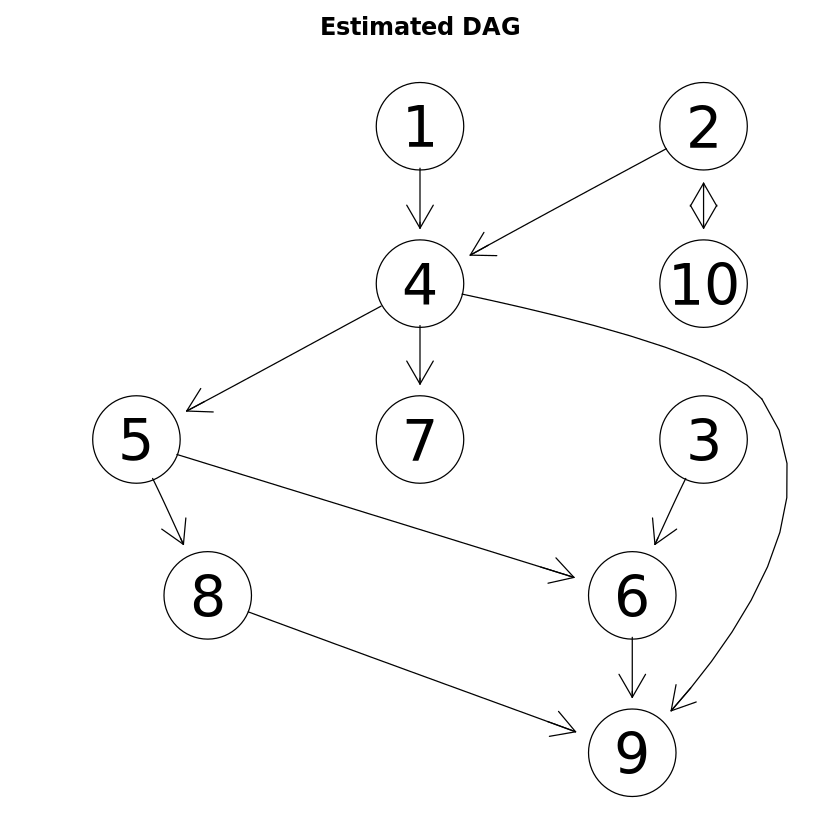

In [13]:
library("pcalg")

# Standard Estimation Procedure as basic evaluation technique


suffStat <- list(C = cor(df), n = nrow(df))

pc.fit <- pc(suffStat, indepTest = gaussCItest, p=ncol(df), alpha = 0.05, conservative = TRUE, verbose = FALSE)

plot(pc.fit, main = "Estimated DAG")


